# Replicating Something like Golden Gate Claude
First, we want to hook the residual stream of our transformer at the middle layer. There has been other work about hooking other parts of a transformer and different layer, but let's just do what anthropic does in the paper.
This is a simplified of the collect_dataset.py file-- we add in support for hf accelerate and save to a .zarr file there. 

In [1]:
# load in olmo
import torch
from psutil import cpu_count
from typing import Any, List, Tuple
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')


def hook_residual_stream(model: AutoModelForCausalLM) -> Tuple[torch.utils.hooks.RemovableHandle, List[torch.Tensor]]:
    activations = []
    
    def hook_fn(module: torch.nn.Module, input: Any, output: torch.Tensor) -> torch.Tensor:
        activations.append(output.detach().cpu())
        return output
        
    middle_layer_idx = model.config.num_hidden_layers -1 #since we have half of the model loaded, grab the "last layer"
    hook = model.model.layers[middle_layer_idx].post_attention_layernorm.register_forward_hook(hook_fn)
    return hook, activations


def collect_activations(model: AutoModelForCausalLM, tokenizer: AutoTokenizer, dataloader: DataLoader, context_length: int = 512) -> List[torch.Tensor]:
    all_activations = []
    hook, activations = hook_residual_stream(model)

    for idx, batch_texts in tqdm(enumerate(dataloader)):
        inputs = tokenizer(batch_texts['text'], return_tensors='pt', padding=True, truncation=True, max_length=context_length)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.inference_mode():
            outputs = model(**inputs)

        batch_activations = activations.copy()
        all_activations.extend(batch_activations) #extend to flatten the activations
        activations.clear()
        if idx >= 10:
            break

    hook.remove()
    return all_activations

model_config = AutoConfig.from_pretrained("allenai/OLMo-2-1124-7B-Instruct")
model_config.num_hidden_layers = model_config.num_hidden_layers//2 #really only have to load half of the model if we're just getting the RS from halfway in, makes a warning
model = AutoModelForCausalLM.from_pretrained("allenai/OLMo-2-1124-7B-Instruct", 
                                            device_map='cuda:0', 
                                            torch_dtype=torch.bfloat16,
                                            attn_implementation="flash_attention_2",
                                            config=model_config)
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-1124-7B-Instruct")

hook, activations = hook_residual_stream(model)

dataset = load_dataset(
    "HuggingFaceFW/fineweb",
    split="train", 
    num_proc=cpu_count(),
    streaming=False,
    name="sample-10BT",
)

dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

all_activations = collect_activations(model, tokenizer, dataloader)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at allenai/OLMo-2-1124-7B-Instruct were not used when initializing Olmo2ForCausalLM: ['model.layers.16.mlp.down_proj.weight', 'model.layers.16.mlp.gate_proj.weight', 'model.layers.16.mlp.up_proj.weight', 'model.layers.16.post_attention_layernorm.weight', 'model.layers.16.post_feedforward_layernorm.weight', 'model.layers.16.self_attn.k_norm.weight', 'model.layers.16.self_attn.k_proj.weight', 'model.layers.16.self_attn.o_proj.weight', 'model.layers.16.self_attn.q_norm.weight', 'model.layers.16.self_attn.q_proj.weight', 'model.layers.16.self_attn.v_proj.weight', 'model.layers.17.mlp.down_proj.weight', 'model.layers.17.mlp.gate_proj.weight', 'model.layers.17.mlp.up_proj.weight', 'model.layers.17.post_attention_layernorm.weight', 'model.layers.17.post_feedforward_layernorm.weight', 'model.layers.17.self_attn.k_norm.weight', 'model.layers.17.self_attn.k_proj.weight', 'model.layers.17.self_attn.o_proj.weight', 'model.layers.17.self_attn.q_norm.weight', 'mo

Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/114 [00:00<?, ?it/s]

10it [00:46,  4.61s/it]


In [ ]:
import math
import torch
import numpy as np
import zarr
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm import tqdm

class ZarrDataset(Dataset):
    """Dataset for loading .zarr directories stored in the data directory"""
    def __init__(self, data_dir, normalize=True):
        self.data_paths = []
        self.normalize = normalize
        
        for path in Path(data_dir).glob("**/*.zarr"):
            if path.is_dir():
                self.data_paths.append(path)
                
        if not self.data_paths:
            raise ValueError(f"No .zarr directories found in {data_dir}")
            
        print(f"Found {len(self.data_paths)} .zarr directories")
        
        first_zarr = zarr.open(str(self.data_paths[0]), mode='r')
        self.vector_dim = first_zarr.shape[1]
        self.total_vectors = 0
        self.zarr_sizes = []
        
        for path in self.data_paths:
            z = zarr.open(str(path), mode='r')
            size = z.shape[0]
            self.zarr_sizes.append(size)
            self.total_vectors += size
            
        print(f"Total vectors: {self.total_vectors}, Vector dimension: {self.vector_dim}")
        self._norm_factor = None
        
    def __len__(self):
        return self.total_vectors
    
    def get_normalization_factor(self):
        """Calculate normalization factor so E[||x||₂] = √n"""
        if self._norm_factor is not None:
            return self._norm_factor
            
        print("Calculating normalization factor...")
        num_samples = min(10000, self.total_vectors)
        sample_indices = np.random.choice(self.total_vectors, num_samples, replace=False)
        
        # Sum of norms (not squared norms)
        sum_norms = 0.0
        
        for idx in tqdm(sample_indices, desc="Sampling for normalization"):
            # Get raw tensor (without normalization)
            tensor = self._get_raw_tensor(idx)
            # Calculate its L2 norm
            norm = torch.linalg.vector_norm(tensor, ord=2).item()
            sum_norms += norm
        
        # Average L2 norm
        avg_norm = sum_norms / num_samples
        
        # Target norm is sqrt(n) where n is input dimension
        target_norm = math.sqrt(self.vector_dim)
        
        self._norm_factor = target_norm / avg_norm
        
        return self._norm_factor
    
    def _get_raw_tensor(self, idx):
        """Get tensor without normalization"""
        for i, size in enumerate(self.zarr_sizes):
            if idx < size:
                z = zarr.open(str(self.data_paths[i]), mode='r')
                return torch.from_numpy(z[idx]).view(torch.bfloat16)
            idx -= size
        raise IndexError(f"Index {idx} out of bounds")
    
    def __getitem__(self, idx):
        tensor = self._get_raw_tensor(idx)
        
        if self.normalize:
            # Apply normalization factor
            norm_factor = self.get_normalization_factor()
            tensor = tensor * norm_factor
            
        return tensor

# Pre-calculate normalization factor once
dataset = ZarrDataset('data/combined_zarr', normalize=False)
# norm_factor = dataset.get_normalization_factor()  # Calculate once

# Then create your dataloader with many workers
dataloader = DataLoader(
    dataset,
    batch_size=4096,
    shuffle=True,
    num_workers=24,  # Using all your cores
    pin_memory=True,
    drop_last=True
)
for idx, data in enumerate(dataloader):
    if idx >= 10000:
        print('nake')
        break
    else:
        print("s")

Found 24 .zarr directories
Total vectors: 280363008, Vector dimension: 4096


# What is the best combo of num_workers and prefetch_factor?

Found 24 .zarr directories
Total vectors: 280363008, Vector dimension: 4096, Total batches: 68448

Testing num_workers = 4, prefetch_factor = 1
Running warm-up phase...
Measuring performance across 1000 batches...
Processed 100 batches. Avg time: 0.0417 seconds per batch
Processed 200 batches. Avg time: 0.0411 seconds per batch
Processed 300 batches. Avg time: 0.0443 seconds per batch
Processed 400 batches. Avg time: 0.0397 seconds per batch
Processed 500 batches. Avg time: 0.0428 seconds per batch
Processed 600 batches. Avg time: 0.0430 seconds per batch
Processed 700 batches. Avg time: 0.0391 seconds per batch
Processed 800 batches. Avg time: 0.0397 seconds per batch
Processed 900 batches. Avg time: 0.0394 seconds per batch

Results for num_workers = 4, prefetch_factor = 1:
Total time for 1000 batches: 41.47 seconds
Average time per batch: 0.0415 seconds
Standard deviation: 0.0335 seconds

Testing num_workers = 4, prefetch_factor = 2
Running warm-up phase...
Measuring performance acr

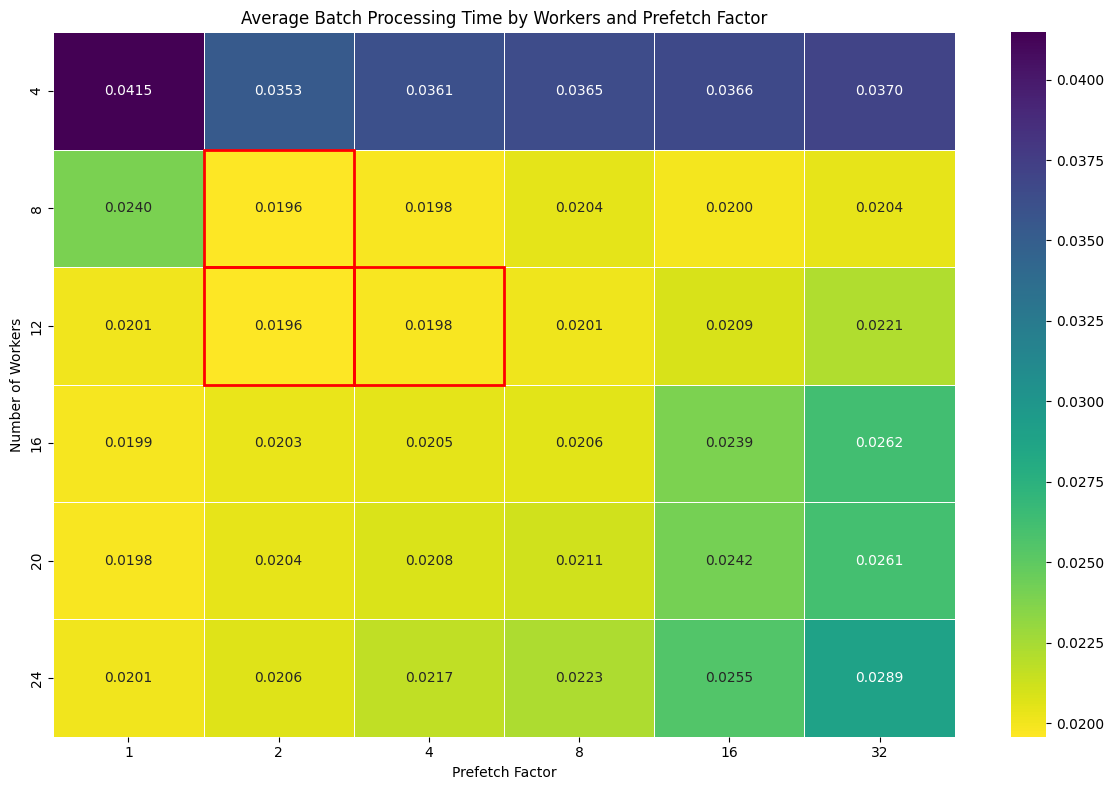

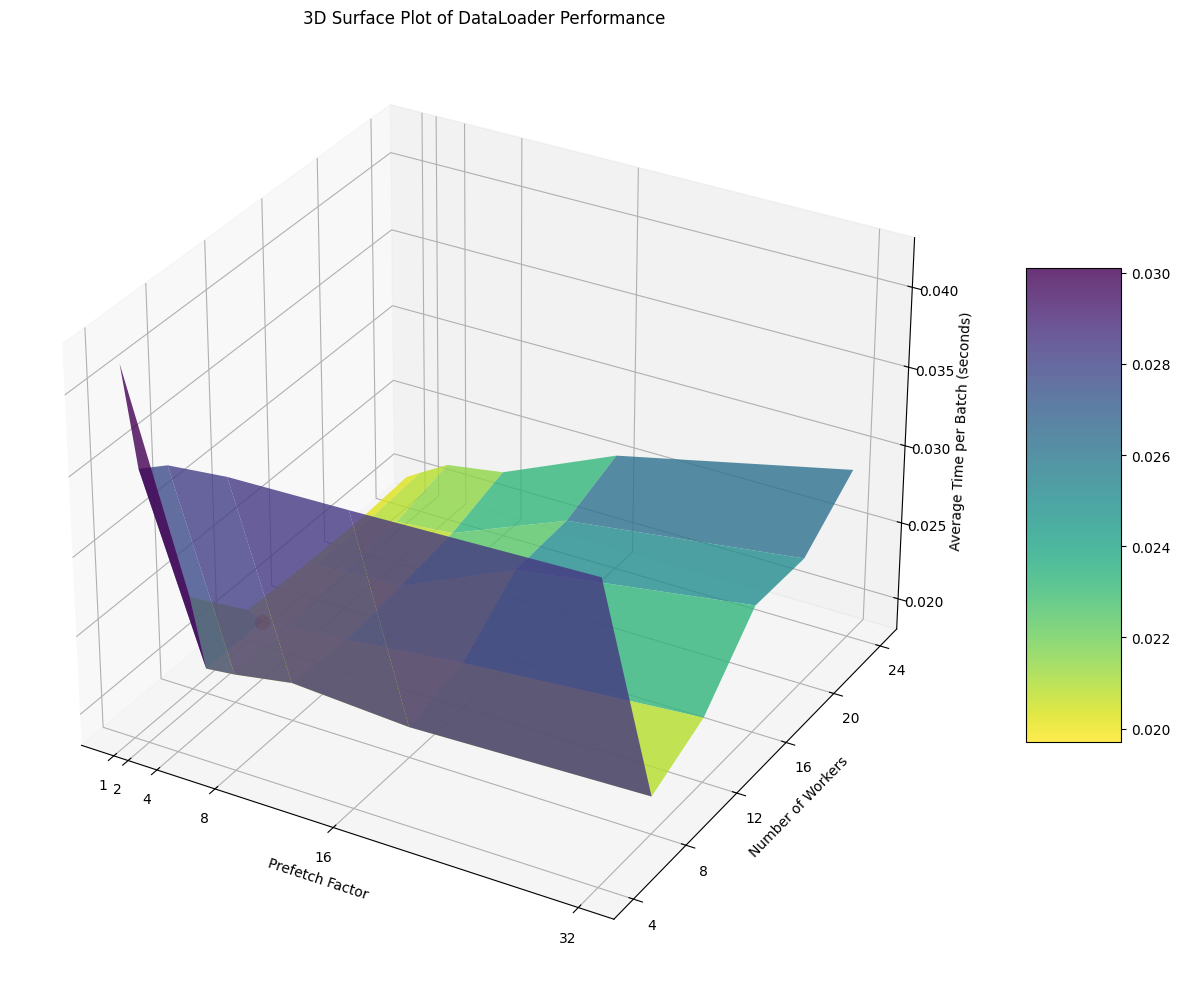

In [ ]:
import math
import torch
import numpy as np
import zarr
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm import tqdm

class ZarrDataset(Dataset):
    """Dataset for loading .zarr directories stored in the data directory with batch loading"""
    def __init__(self, data_dir, batch_size=4096, normalize=True):
        self.data_paths = []
        self.normalize = normalize
        self.batch_size = batch_size
        
        # Find all zarr directories
        for path in Path(data_dir).glob("**/*.zarr"):
            if path.is_dir():
                self.data_paths.append(path)
                
        if not self.data_paths:
            raise ValueError(f"No .zarr directories found in {data_dir}")
        print(f"Found {len(self.data_paths)} .zarr directories")
        
        # Get dimensions from first zarr file
        first_zarr = zarr.open(str(self.data_paths[0]), mode='r')
        self.vector_dim = first_zarr.shape[1]
        
        # Calculate size of each zarr file and total number of vectors
        self.total_vectors = 0
        self.zarr_sizes = []
        self.zarr_cumulative_sizes = [0]  # Starts with 0
        
        for path in self.data_paths:
            z = zarr.open(str(path), mode='r')
            size = z.shape[0]
            self.zarr_sizes.append(size)
            self.total_vectors += size
            self.zarr_cumulative_sizes.append(self.zarr_cumulative_sizes[-1] + size)
            
        print(f"Total vectors: {self.total_vectors}, Vector dimension: {self.vector_dim}, Total batches: {self.total_vectors//self.batch_size}")
        
        # Normalization
        self._norm_factor = None
        
    def __len__(self):
        return self.total_vectors // self.batch_size  # Return number of batches
    
    def get_normalization_factor(self):
        """Calculate normalization factor so E[||x||₂] = √n"""
        if self._norm_factor is not None:
            return self._norm_factor
            
        print("Calculating normalization factor...")
        num_samples = min(10000, self.total_vectors)
        sample_indices = np.random.choice(self.total_vectors, num_samples, replace=False)
        
        # Group indices by zarr file for efficient loading
        grouped_indices = {}
        for idx in sample_indices:
            zarr_idx, local_idx = self._get_zarr_indices(idx)
            if zarr_idx not in grouped_indices:
                grouped_indices[zarr_idx] = []
            grouped_indices[zarr_idx].append(local_idx)
        
        # Sum of norms (not squared norms)
        sum_norms = 0.0
        for zarr_idx, local_indices in tqdm(grouped_indices.items(), desc="Sampling for normalization"):
            z = zarr.open(str(self.data_paths[zarr_idx]), mode='r')
            # Load all samples at once for this zarr file
            batch = torch.from_numpy(z[local_indices]).to(torch.bfloat16)
            # Calculate norms and sum them
            norms = torch.linalg.vector_norm(batch, ord=2, dim=1)
            sum_norms += norms.sum().item()
            
        # Average L2 norm
        avg_norm = sum_norms / num_samples
        
        # Target norm is sqrt(n) where n is input dimension
        target_norm = math.sqrt(self.vector_dim)
        self._norm_factor = target_norm / avg_norm
        print(f"Normalization factor: {self._norm_factor}")
        return self._norm_factor
    
    def _get_zarr_indices(self, global_idx: int):
        """Convert global index to (zarr_file_idx, local_idx)"""
        for i in range(len(self.zarr_sizes)):
            if global_idx < self.zarr_cumulative_sizes[i+1]:
                return i, global_idx - self.zarr_cumulative_sizes[i]
        raise IndexError(f"Index {global_idx} out of bounds")
    
    def __getitem__(self, batch_idx):
        # Convert batch index to global start index
        global_start_idx = batch_idx * self.batch_size
        
        # This will store our batch
        batch = []
        remaining = self.batch_size
        current_global_idx = global_start_idx
        
        # Keep collecting vectors until we have a full batch
        while remaining > 0:
            # Find which zarr file this index belongs to
            zarr_idx, local_idx = self._get_zarr_indices(current_global_idx)
            
            # Open the zarr file
            z = zarr.open(str(self.data_paths[zarr_idx]), mode='r')
            
            # Calculate how many elements we can take from current zarr file
            zarr_size = self.zarr_sizes[zarr_idx]
            elements_to_take = min(remaining, zarr_size - local_idx)
            
            # Load the chunk
            chunk = torch.from_numpy(z[local_idx:local_idx + elements_to_take]).to(torch.bfloat16)
            batch.append(chunk)
            
            # Update counters
            remaining -= elements_to_take
            current_global_idx += elements_to_take
            
            # If we've reached the end of the dataset, wrap around
            if current_global_idx >= self.total_vectors:
                current_global_idx = 0
                
        # Concatenate all chunks into a single batch
        batch = torch.cat(batch, dim=0)
        
        # Apply normalization if needed
        if self.normalize and self._norm_factor is not None:
            batch = batch * self._norm_factor
            
        return batch

import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns

# Create dataset with batch loading
dataset = ZarrDataset('data/combined_zarr', batch_size=4096, normalize=False)yy

# Define grid search parameters
prefetch_factors = [1, 2, 4, 8, 16, 32]
num_workers_options = [4, 8, 12, 16, 20, 24]

# Number of batches to process for each test
NUM_TEST_BATCHES = 1000  # Sufficient for statistical significance
# Number of warmup batches (to avoid cold start bias)
NUM_WARMUP_BATCHES = 100

# List to store all results
all_results = []

# Run grid search over both parameters
for num_workers in num_workers_options:
    for prefetch_factor in prefetch_factors:
        print(f"\n{'='*50}")
        print(f"Testing num_workers = {num_workers}, prefetch_factor = {prefetch_factor}")
        print(f"{'='*50}")
        
        # Create dataloader with current parameters
        dataloader = DataLoader(
            dataset,
            batch_size=1,  # Each "item" is already a batch
            shuffle=True,
            num_workers=num_workers,
            prefetch_factor=prefetch_factor,
            pin_memory=True,
            drop_last=False
        )
        
        # Warm-up phase (to ensure fair comparison)
        print("Running warm-up phase...")
        for idx, batch in enumerate(dataloader):
            batch = batch.squeeze(0)  # Reshape because DataLoader adds an extra dimension
            if idx >= NUM_WARMUP_BATCHES - 1:
                break
        
        # Measure performance for test batches
        print(f"Measuring performance across {NUM_TEST_BATCHES} batches...")
        timings = []
        
        start_time = time.time()
        batch_start_time = time.time()
        
        for idx, batch in enumerate(dataloader):
            # Process batch
            batch = batch.squeeze(0)
            
            # Record timing for each batch
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            timings.append(batch_time)
            batch_start_time = time.time()
            
            # Report progress periodically
            if idx % 100 == 0 and idx > 0:
                print(f"Processed {idx} batches. Avg time: {np.mean(timings[-100:]):.4f} seconds per batch")
            
            # Exit after processing the desired number of batches
            if idx >= NUM_TEST_BATCHES - 1:
                break
        
        # Calculate statistics
        total_time = sum(timings)
        avg_time = total_time / len(timings)
        std_dev = np.std(timings)
        
        # Store results
        all_results.append({
            'num_workers': num_workers,
            'prefetch_factor': prefetch_factor,
            'avg_time_per_batch': avg_time,
            'total_time': total_time,
            'std_dev': std_dev
        })
        
        print(f"\nResults for num_workers = {num_workers}, prefetch_factor = {prefetch_factor}:")
        print(f"Total time for {NUM_TEST_BATCHES} batches: {total_time:.2f} seconds")
        print(f"Average time per batch: {avg_time:.4f} seconds")
        print(f"Standard deviation: {std_dev:.4f} seconds")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(all_results)

# Find top 3 performers
top3 = results_df.nsmallest(3, 'avg_time_per_batch')

print("\n" + "="*50)
print("TOP 3 CONFIGURATIONS")
print("="*50)
for i, (idx, row) in enumerate(top3.iterrows()):
    workers = row['num_workers']
    prefetch = row['prefetch_factor']
    avg_time = row['avg_time_per_batch']
    print(f"{i+1}. num_workers = {workers}, prefetch_factor = {prefetch}: {avg_time:.4f} seconds per batch")

# Create heatmap visualization
plt.figure(figsize=(12, 8))

# Reshape data for heatmap
heatmap_data = results_df.pivot(
    index='num_workers', 
    columns='prefetch_factor', 
    values='avg_time_per_batch'
)

# Create the heatmap
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt='.4f', 
    cmap='viridis_r',  # _r for reversed (lower values = better = greener)
    linewidths=0.5
)
plt.title('Average Batch Processing Time by Workers and Prefetch Factor')
plt.xlabel('Prefetch Factor')
plt.ylabel('Number of Workers')

# Mark top 3 configurations on the heatmap
for _, row in top3.iterrows():
    workers = row['num_workers']
    prefetch = row['prefetch_factor']
    ax.add_patch(plt.Rectangle(
        (prefetch_factors.index(prefetch), num_workers_options.index(workers)),
        1, 1, fill=False, edgecolor='red', lw=2
    ))

plt.tight_layout()
plt.savefig('dataloader_grid_search.png', dpi=300)

# Create 3D surface plot for better visualization
plt.figure(figsize=(14, 10))
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D plot
X, Y = np.meshgrid(prefetch_factors, num_workers_options)
Z = heatmap_data.values

# Create 3D surface plot
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis_r', edgecolor='none', alpha=0.8)

# Add colorbar
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Set labels and title
ax.set_xlabel('Prefetch Factor')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Average Time per Batch (seconds)')
ax.set_title('3D Surface Plot of DataLoader Performance')

# Set tick labels
ax.set_xticks(prefetch_factors)
ax.set_yticks(num_workers_options)

# Mark top performer with a red dot
best_config = top3.iloc[0]
ax.scatter(
    [best_config['prefetch_factor']], 
    [best_config['num_workers']], 
    [best_config['avg_time_per_batch']],
    color='red', s=100, marker='o'
)

plt.tight_layout()
plt.savefig('dataloader_3d_surface.png', dpi=300)

# Extrapolate results to estimate full dataset processing time
print("\n" + "="*50)
print("ESTIMATED FULL DATASET PROCESSING TIME (68,448 BATCHES)")
print("="*50)
total_batches = 68_448
for i, (idx, row) in enumerate(top3.iterrows()):
    workers = row['num_workers']
    prefetch = row['prefetch_factor']
    avg_time = row['avg_time_per_batch']
    estimated_total = avg_time * total_batches
    hours = estimated_total // 3600
    minutes = (estimated_total % 3600) // 60
    seconds = estimated_total % 60
    print(f"{i+1}. num_workers = {workers}, prefetch_factor = {prefetch}: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s ({estimated_total:.2f} seconds)")

# Export results to CSV for future reference
results_df.to_csv('dataloader_grid_search_results.csv', index=False)
print("\nDetailed results have been saved to 'dataloader_grid_search_results.csv'")

